# Collect data for nectar experiment

In [1]:
import nectarUtils
from nectarUtils import *
import nectarUtils as nu

import beeDataAcq
from beeDataAcq import cameraSetup, saveVid

import importlib
import shutil

from multiprocessing import Process, Pipe


%matplotlib inline
print(sys.version)
print(sys.executable)

# define directories
baseDir = os.getcwd()

# may want to make this directory somewhere else, if dropbox becomes a problem
dataDir = r"D:\Dropbox\AcademiaDropbox\UW\BeeDecisionProject\NectarData"
if not os.path.isdir(dataDir):
    os.mkdir(dataDir)

figDir = r"D:\Dropbox\AcademiaDropbox\UW\BeeDecisionProject\NectarFigs"
if not os.path.isdir(figDir):
    os.mkdir(figDir)

3.5.4 |Anaconda custom (64-bit)| (default, Sep 19 2017, 08:15:17) [MSC v.1900 64 bit (AMD64)]
C:\Users\Combes4\Anaconda2\envs\NectarCamera\python.exe


In [2]:
# check cameras
parent_conn, child_conn = Pipe()
p = Process(target=cameraSetup.main, args=(child_conn, ))
p.start()

In [ ]:
# send stop signal
parent_conn.send("stop")

In [3]:
# list serial ports
nu.serial_ports()

['COM4', 'COM8']

In [4]:
# connect to com8
PORT1 = "COM4"
connected1 = False
if "ser1" in globals():
    ser1.close()
ser1 = serial.Serial(PORT1,9600, timeout=1.0) # stop if no data comes in 1 second
while not connected1:
    serin1 = ser1.read()
    connected1 = True
    print("connected to arduino on " + PORT1)
str(ser1.readline().decode("UTF-8"))    

connected to arduino on COM4


' Setup complete\r\n'

In [5]:
# connect to com8
PORT2 = "COM8"
connected2 = False
if "ser2" in globals():
    ser2.close()
ser2 = serial.Serial(PORT2,9600, timeout=1.0) # stop if no data comes in 1 second
while not connected2:
    serin2 = ser2.read()
    connected2 = True
    print("connected to arduino on " + PORT2)
str(ser2.readline().decode("UTF-8"))    

connected to arduino on COM8


' Setup complete\r\n'

In [61]:
ser2.write("ff".encode("utf-8")) # com8

2

In [94]:
ser1.write("ff".encode("utf-8")) # com4

2

In [95]:
# calibrate both at the same time

_ = importlib.reload(nectarUtils)
cal1, cal2 = nu.multiCalibrate(ser1, ser2)

In [96]:
#cal1 = nu.multiCalibrate(ser1) # can use this function to do a single calibration

#cal2 = nu.multiCalibrate(ser2)

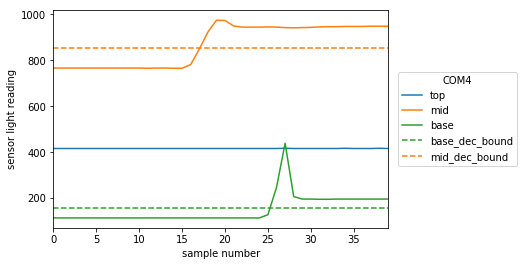

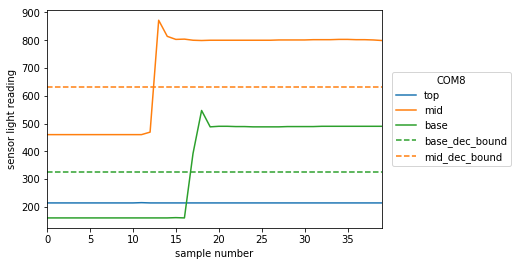

In [97]:
_ = importlib.reload(nectarUtils)
nu.plotCalibration(cal1)
nu.plotCalibration(cal2)


TimeStamp is enabled.


TimeStamp is enabled.



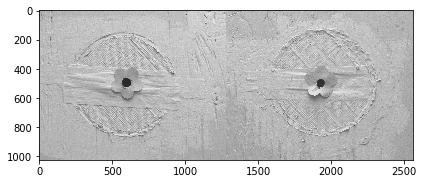

In [98]:
# get image calibration
calImg1, calImg2 = beeDataAcq.saveVid.getCalibrationImages()

In [103]:
_ = importlib.reload(nectarUtils)
_ = importlib.reload(beeDataAcq.saveVid)
_ = importlib.reload(beeDataAcq.cameraSetup)

In [104]:
# start video (asynchronously) -- pthe process is stopped with parent_conn.send("stop")
parent_conn, child_conn = Pipe()
p = Process(target=saveVid.main, args=(child_conn, calImg1, calImg2 ))
p.start()


# this is not asynchronous -- you must press "q" in the command prompt twice to exit
try:
    dat1, dat1_file, dat2, dat2_file= nu.multiReadAndSave(ser1, ser2, cal1, cal2,
                                                           dataDir = dataDir, maxTime = 60*20)
    print("DONE")
except: 
    print("timeout")
# stops video recording
parent_conn.send("stop")

4.0 seconds elapsed
5.0 seconds elapsed
ACTION
ACTION
ACTION
69.0 seconds elapsed
76.0 seconds elapsed
124.0 seconds elapsed
132.0 seconds elapsed
204.0 seconds elapsed
214.0 seconds elapsed
284.0 seconds elapsed
303.0 seconds elapsed
386.0 seconds elapsed
395.0 seconds elapsed
471.0 seconds elapsed
478.0 seconds elapsed
547.0 seconds elapsed
555.0 seconds elapsed
620.0 seconds elapsed
628.0 seconds elapsed
ACTION
705.0 seconds elapsed
717.0 seconds elapsed
keyboard break
keyboard break
DONE


In [105]:
# stops video recording
parent_conn.send("stop")

In [107]:
# post-processing of data
if parent_conn.poll():
    movieFileName = parent_conn.recv()
else:
    movieFileName = "unknown"
print(movieFileName)

# combine datasets
dat_combined = dat1.append(pd.DataFrame( dat2), ignore_index=True)
dat_combined["video_file"] = np.nan
dat_combined.loc[0,"video_file"] = movieFileName
#dat_combined.loc[1, "notes"] = movieFileName + str("    MovieFile")
dat_combined.head()

# save combined dataset
dat_combined.to_csv(os.path.join(dataDir, np.sort([dat2_file, dat1_file])[0].replace(".", "___cmbnd.")), index = False)

# remove individual datasets
if os.path.isfile(os.path.join(dataDir, dat1_file)):
    os.remove(os.path.join(dataDir, dat1_file))
else: 
    print("File doesn't exist")
if os.path.isfile(os.path.join(dataDir, dat2_file)):
    os.remove(os.path.join(dataDir, dat2_file)) 
else: 
    print("File doesn't exist")


# combine movie and nectar files into one
movieFiles2Move = [fname 
             for fname in os.listdir(os.path.dirname(movieFileName)) 
             if fname.startswith(os.path.basename(movieFileName))]

nectarFile2Copy = os.path.join(dataDir, np.sort([dat2_file, dat1_file])[0].replace(".", "___cmbnd."))

# make new folder
CombinedFolder = os.path.join(dataDir, np.sort([dat2_file, dat1_file])[0].replace(".csv", ""))

if not os.path.isdir(CombinedFolder):
    os.mkdir(CombinedFolder)

# MOVE MOVIES
try: 
    for i in range(len(movieFiles2Move)):
        shutil.move(os.path.join(os.path.dirname(movieFileName), movieFiles2Move[i]), 
                    os.path.join(CombinedFolder, movieFiles2Move[i]))
    print(len(movieFiles2Move), " movie files moved")
except: 
    print("can't move movies")

    
# MOVE DATA
try:
    shutil.move(nectarFile2Copy, os.path.join(CombinedFolder, os.path.basename(nectarFile2Copy)))
except: 
    print("can't move nectar data")

C:\Users\Combes4\Desktop\TempVids\2019_04_02__14_43_33_295
3  movie files moved


In [110]:
d1 = os.path.join(CombinedFolder, os.path.basename(nectarFile2Copy))

In [119]:
d2 = os.path.join(CombinedFolder, os.path.basename(movieFileName) + ".csv")
d2

'D:\\Dropbox\\AcademiaDropbox\\UW\\BeeDecisionProject\\NectarData\\2019_04_02__14_43_21_775574\\2019_04_02__14_43_33_295.csv'

In [178]:
dd1 = pd.read_csv(d1).reset_index()
dd1['timestamp'] = pd.to_datetime(dd1['timestamp'])
dd1.tail()

,index,base,limit_1,limit_2,mid,notes,port,timestamp,top,video_file
20035,20035,161,0,0,810,NaN,COM8,2019-04-02 14:56:01.951350,216,NaN
20036,20036,161,0,0,810,NaN,COM8,2019-04-02 14:56:02.012314,216,NaN
20037,20037,161,0,0,810,NaN,COM8,2019-04-02 14:56:02.061286,216,NaN
20038,20038,161,0,0,810,NaN,COM8,2019-04-02 14:56:02.132859,216,NaN
20039,20039,161,0,0,810,NaN,COM8,2019-04-02 14:56:02.184216,216,NaN


In [179]:
dd2 = pd.read_csv(d2).reset_index()
dd2['timestamp'] = pd.to_datetime(dd2['datetime'], format="%Y_%m_%d__%H_%M_%S_%f")
dd2.head()

,index,datetime,beeInImage1,darkArea1,beeInImage2,darkArea2,timestamp
0,0,2019_04_02__14_43_33_296,False,0.0,False,0.0,2019-04-02 14:43:33.296
1,1,2019_04_02__14_43_35_155,False,0.0,False,0.0,2019-04-02 14:43:35.155
2,2,2019_04_02__14_43_35_552,False,0.0,False,0.0,2019-04-02 14:43:35.552
3,3,2019_04_02__14_43_35_898,False,0.0,False,0.0,2019-04-02 14:43:35.898
4,4,2019_04_02__14_43_36_263,False,0.0,False,0.0,2019-04-02 14:43:36.263


In [180]:
sd1 = dd1.loc[:, ["base", "mid", "top", "port", "timestamp"]].sort_values('timestamp')
print(sd1.shape)
sd2 = dd2.loc[:, ["beeInImage1", "beeInImage2", "timestamp"]]
print(sd2.shape)

(20040, 5)
(1342, 3)


In [204]:
MergedCameraNectar = pd.merge_asof( sd1.reset_index(),sd2.reset_index(), on = "timestamp", direction = "nearest")

In [205]:
MergedCameraNectar.tail()

,index_x,base,mid,top,port,timestamp,index_y,beeInImage1,beeInImage2
20035,20037,161,810,216,COM8,2019-04-02 14:56:02.061286,1340,False,False
20036,20038,161,810,216,COM8,2019-04-02 14:56:02.132859,1340,False,False
20037,10040,115,955,417,COM4,2019-04-02 14:56:02.133246,1340,False,False
20038,20039,161,810,216,COM8,2019-04-02 14:56:02.184216,1340,False,False
20039,10041,115,955,417,COM4,2019-04-02 14:56:02.185215,1340,False,False


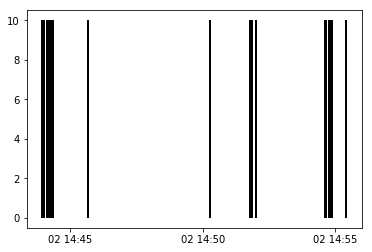

In [206]:
MergedCameraNectar.loc[MergedCameraNectar.beeInImage1 == True, "timestamp"]
plt.vlines(np.array(MergedCameraNectar.loc[MergedCameraNectar.beeInImage1 == True, "timestamp"]), 
           ymin = 0, ymax = 10)

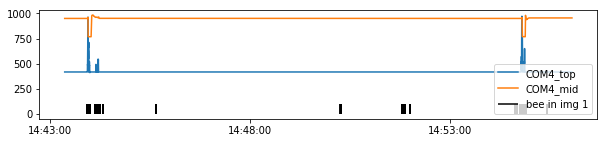

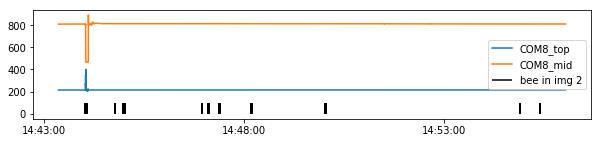

In [231]:
fig, ax = plt.subplots(figsize = [10,2])
ax.plot(MergedCameraNectar.loc[MergedCameraNectar.port == "COM4", "timestamp"], 
        MergedCameraNectar.loc[MergedCameraNectar.port == "COM4", "top"], label = "COM4_top")
ax.plot(MergedCameraNectar.loc[MergedCameraNectar.port == "COM4", "timestamp"], 
        MergedCameraNectar.loc[MergedCameraNectar.port == "COM4", "mid"], label = "COM4_mid")
ax.vlines(np.array(MergedCameraNectar.loc[MergedCameraNectar.beeInImage1 == True, "timestamp"]), 
           ymin = 0, ymax = 100, label = "bee in img 1")
plt.legend()
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(myFmt)


fig, ax = plt.subplots(figsize = [10,2])

ax.plot(MergedCameraNectar.loc[MergedCameraNectar.port == "COM8", "timestamp"], 
        MergedCameraNectar.loc[MergedCameraNectar.port == "COM8", "top"],  label = "COM8_top")
ax.plot(MergedCameraNectar.loc[MergedCameraNectar.port == "COM8", "timestamp"], 
        MergedCameraNectar.loc[MergedCameraNectar.port == "COM8", "mid"], label = "COM8_mid")
ax.vlines(np.array(MergedCameraNectar.loc[MergedCameraNectar.beeInImage2 == True, "timestamp"]), 
           ymin = 0, ymax = 100, label = "bee in img 2")
plt.legend()
ax.xaxis.set_major_formatter(myFmt)
plt.show()


In [ ]:
dataDir

In [ ]:
tmpDat = np.empty(3, dtype = '<U26')

In [ ]:
import datetime
tmpDat[0] = str(datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S_%f")[:-3])

In [ ]:
tmpDat

# Try to save video as something besides AVI

In [ ]:

import numpy as np
import cv2
import datetime
import PyCapture2 as fc2
import sys
import time
import os
import re
import skimage.io as io
import csv
from itertools import islice


import beeDataAcq.cameraSetup as cs

In [ ]:
def saveVidHelper(cam, cam2, fileFormat, fileName, fileName2, frameRate, maxImgs = 500):
    
    numImages = 0

    avi = fc2.AVIRecorder()
    avi2 = fc2.AVIRecorder()

    for i in range(maxImgs):
        
        try:
            image = cam.retrieveBuffer()
            image2 = cam2.retrieveBuffer()
            
            
        except fc2.Fc2error as fc2Err:
            print("Error retrieving buffer : ", fc2Err)
            continue

        print("Grabbed image {}".format(i))

        if (i == 0):
            if fileFormat == "AVI":
                avi.AVIOpen(fileName, frameRate)
                avi2.AVIOpen(fileName2, frameRate)
            elif fileFormat == "MJPG":
                avi.MJPGOpen(fileName, frameRate, 75)
                avi2.MJPGOpen(fileName2, frameRate, 75)
            elif fileFormat == "H264":
                avi.H264Open(fileName, frameRate, image.getCols(), image.getRows(), 1000000)
                avi2.H264Open(fileName2, frameRate, image2.getCols(), image2.getRows(), 1000000)
            else:
                print("Specified format is not available.")
                return
            
            # show still image
            img = np.concatenate((cs.img2array(image), cs.img2array(image2)), axis = 1)

            # Display the resulting frame
            cv2.imshow('image', img)
            

        # break when "q" is pressed on keyboard
        k = cv2.waitKey(1) & 0xFF

        if (k  == ord('q')) or (k == 27):
            for jj in range(10):
                cv2.destroyAllWindows()
            break

        # refref add image timestamp
        avi.append(image)
        avi2.append(image2)
        numImages += 1
        print("Appended image {}...".format(i))

    # close windows if loop ends
    for jj in range(10):
        cv2.destroyAllWindows()
        
    print("Appended {} images to {} file: {}...".format(numImages, fileFormat, fileName))
    avi.close()
    avi2.close()

In [ ]:
bus = fc2.BusManager()
numCams = bus.getNumOfCameras()


c = fc2.Camera()
c.connect(bus.getCameraFromIndex(0))
d = fc2.Camera()
d.connect(bus.getCameraFromIndex(1))

# start capture
cs.enableEmbeddedTimeStamp(c, True)
c.startCapture()
cs.enableEmbeddedTimeStamp(c, True)
d.startCapture()

In [ ]:
saveVidHelper(c,d, "MJPG",  br"C:\Users\Combes4\Desktop\TempVids\V1_M", 
              br"C:\Users\Combes4\Desktop\TempVids\V2_MJPG", 
              5, maxImgs = 10)

In [ ]:
avi = fc2.AVIRecorder()
image = c.retrieveBuffer()

In [ ]:
# avi.H264Open(br"C:\Users\Combes4\Desktop\TempVids\V1_h264", 5, image.getCols(), image.getRows(), 1000000)
avi.MJPGOpen(br"C:\Users\Combes4\Desktop\TempVids\V1_MJPG", 5, 75)

In [ ]:
avi.append(image)

In [ ]:
avi.close()

In [ ]:
br"C:\Users\Combes4\Desktop\TempVids\V1"

# video processing

In [ ]:
import numpy as np
import cv2
import datetime
import PyCapture2 as fc2
import sys
import time
import os
import re
import skimage.io as io
%matplotlib inline
import matplotlib.pyplot as plt

import beeDataAcq.cameraSetup
import beeDataAcq.saveVid

In [ ]:
import importlib
_ = importlib.reload(beeDataAcq.saveVid)
_ = importlib.reload(beeDataAcq.cameraSetup)

In [ ]:
calImg1, calImg2 = beeDataAcq.saveVid.getCalibrationImages()

In [ ]:
bee

In [ ]:
calImg11, calImg22 = beeDataAcq.saveVid.getCalibrationImages()

In [ ]:
calImg111, calImg222 = beeDataAcq.saveVid.getCalibrationImages()

In [ ]:
calImg1

In [ ]:
# # black is 0, white is 255
# print(calImg1[0:3, 0:3])
# print(calImg111[0:3, 0:3])

In [ ]:
# # How much could it possibly change?
# # how much darker can the image get? -- darker == lower numbers
# possibleChange = calImg1[0:3, 0:3]
# possibleChange

In [ ]:
calImg1.dtype == "int16"

# Start analysis

In [ ]:
def beeInImage(calImg, frame):
    '''
    Returns True if a bee is detected in the image
    
    Detects bees by size of dark blobs in the image
    
    Parameters
    ----------
    calImg : np.array(int16) -- note that it is NOT uint8, which is default
        Calibration image (no bee visible)
    frame : np.array(int16) 
        frame of current image to compare with calibration image

    Returns
    -------
    bool
        True if there is a bee in the frame
   
    '''
    
    # check dtype
    if calImg.dtype != "int16":
        calImg = calImg.astype('int16') 
    if frame.dtype != "int16":
        frame = frame.astype('int16')
    
    # get image difference
    im1Diff = (calImg - frame) 
    height,width = im1Diff.shape
    
    # crop image to a circle
    mask_circ = np.zeros((height,width), np.uint8)
    cv2.circle(mask_circ,(int(width/2),int(height/2)),int(np.min([width,height])/2),(255),thickness=-1)
    imDiff_cropped = cv2.bitwise_and(im1Diff, im1Diff, mask=mask_circ)

    # gaussian blur
    blur = cv2.GaussianBlur(imDiff_cropped,(121,121),0)
    
    # get darker sections (positive threshold gives dark areas)
    ret_dark,th3_dark = cv2.threshold(blur,70,255,cv2.THRESH_BINARY)
    
    # get areas
    img, cnts, _ = cv2.findContours(th3_dark.astype('uint8'), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.ones(th3_dark.shape[:2], dtype="uint8") * 0 # create a blank black mask

    areas = np.array([cv2.contourArea(c, False) for c in cnts])

    # if there is at least one area over XX, then it's a bee
    return(any(areas > 1000))

    

In [ ]:




# refref: only look at circular part of image
# negative means it got lighter, positive means it got darker
im1Diff = (calImg1[::10,::10] - calImg11[::10,::10]) 
height,width = im1Diff.shape
mask_circ = np.zeros((height,width), np.uint8)

cv2.circle(mask_circ,(int(width/2),int(height/2)),int(np.min([width,height])/2),(255),thickness=-1)

# io.imshow(mask_circ)
imDiff_cropped = cv2.bitwise_and(im1Diff, im1Diff, mask=mask_circ)
io.imshow(imDiff_cropped)


In [ ]:
# # threshold image where it changed a lot (more than 20)
# plt.matshow((np.abs(im1Diff)>10) * 1, vmin=0, vmax=1)
# plt.colorbar()
# plt.show()

In [ ]:
# # convert to 8bit
# #img8 = ((im1Diff + 256)/2).astype('uint8')
# img8 = ((np.abs(im1Diff)>10) * 255).astype('uint8')
# img8 = cv2.bitwise_not(img8)

In [ ]:
# io.imshow(img8)

In [ ]:
121/16

In [ ]:
# Gaussian filtering
# negative is lighter, positive is darker
# REFREF: in function on other page, chage 121 to 11
blur = cv2.GaussianBlur(imDiff_cropped,(5,5),0)
plt.matshow(blur)
plt.colorbar()

In [ ]:
# negative means it got lighter (unless image is inverted)

                #image, threshold, maxvalue, type of threshold
                # return max val if image > threshValue
# cv2.threshold(blur,   50,     255,    cv2.THRESH_BINARY)


# I manually chose the threshold

# get darker sections
ret_dark,th3_dark = cv2.threshold(blur,70,255,cv2.THRESH_BINARY)



# get lighter sections
ret_light,th3_light = cv2.threshold(blur,-10,255,cv2.THRESH_BINARY_INV)
# I manually chose a threshold of 10above
plt.matshow(cv2.bitwise_not(th3_dark))
plt.colorbar()
plt.title("Darker areas", y=-0.2)
plt.show()
plt.matshow(th3_light)
plt.title("lighter areas", y=-0.2)
plt.colorbar()
plt.show()

In [ ]:
# show darker and lighter colors
plt.matshow(th3_light + cv2.bitwise_not(th3_dark))
plt.colorbar()
plt.show()

In [ ]:
# get areas
img, cnts, _ = cv2.findContours(th3_dark.astype('uint8'), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
mask = np.ones(th3_dark.shape[:2], dtype="uint8") * 0 # create a blank black mask

areas = np.array([cv2.contourArea(c, False) for c in cnts])


# calculate moments of binary image
def getCenter(contour):
    M = cv2.moments(contour)
    # calculate x,y coordinate of center
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return([cX, cY])

centers = np.array([getCenter(c) for c in cnts])
centers
# if there is at least one area over XX, then it's a bee

In [ ]:
np.argmax(areas)

In [ ]:
# fill small holes, but only for dark area -- refref might not even need this
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4,4))
erosion = cv2.erode(th3_dark,kernel,iterations = 3)
dilation = cv2.dilate(erosion, kernel, iterations = 3)

img, cnts, _ = cv2.findContours(dilation.copy().astype('uint8'), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
mask = np.ones(im1Diff.shape[:2], dtype="uint8") * 0 # create a blank black mask

areas = [cv2.contourArea(c, False) for c in cnts]

# if there is at least one area over XX, then it's a bee

areas

In [ ]:
# find bad contours
def is_contour_good(c, img):
    # approximate the contour
    area1 = cv2.contourArea(c, False) 
    print(area1)    
    if area1 < 1000:
        return(False)
        print("Bad Contour")
    else:
        return(True)

In [ ]:
# loop over the contours
for c in cnts:
    # if the contour is good, draw it on the mask (draw white on a black background)
    if is_contour_good(c, blur):
        print("contour drawn")
        cv2.drawContours(mask, [c], -1, np.random.randint(100, 255), -1)

        io.imshow(mask)
        plt.show()


In [ ]:
img, cts, _ = cv2.findContours(mask.copy(),  cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
len(cts)

In [ ]:
io.imshow(im_with_keypoints)

In [ ]:
cv2.imshow("Keypoints", im_with_keypoints)
cv2.waitKey(0)


In [ ]:
cv2.destroyAllWindows()

In [ ]:
# Set up the detector with default parameters.
im=cv2.bitwise_not(im1Diff)

params = cv2.SimpleBlobDetector_Params()
detector = cv2.SimpleBlobDetector_create(params)


# Detect blobs.
keypoints = detector.detect(im)
im=cv2.bitwise_not(im)

In [ ]:
percChange = np.divide(im1Diff, possibleChange)

In [ ]:
percChange

In [ ]:
np.max(percChange)

In [ ]:
io.imshow(percChange)

In [ ]:
plt.matshow(calImg1)
plt.colorbar()
plt.show()
plt.matshow(calImg11)
plt.colorbar()
plt.show()

In [ ]:
im1Diff = calImg1 - calImg11
np.min(im1Diff)

In [ ]:
im1Diff = np.subtract(calImg2, calImg22)

In [ ]:
io.imshow(im1Diff)

In [ ]:
io.imshow(np.abs(im1Diff))

In [ ]:
# calculate change as portion of possible change

In [ ]:
plt.matshow(im1Diff)
plt.colorbar()

In [ ]:
np.min(im1Diff)

# Try to speed up im2array

In [ ]:
import numpy as np
import cv2
import datetime
import PyCapture2 as fc2
import sys
import time
import os
import re
import skimage.io as io
import msvcrt

In [ ]:
bus = fc2.BusManager()
numCams = bus.getNumOfCameras()
print("Number of cameras detected: ", numCams)
if not numCams:
    #raise ValueError("Insufficient number of cameras. Exiting...")
    print("Insufficient number of cameras. Exiting...")
    exit()


# print camera info
c = fc2.Camera()
c.connect(bus.getCameraFromIndex(0))


d = fc2.Camera()
d.connect(bus.getCameraFromIndex(1))


# start capture

c.startCapture()

d.startCapture()

In [ ]:
def img2array(image):
    return(np.array(image.getData(), dtype="uint8").reshape( (image.getRows(), image.getCols()) ))

In [ ]:
# start here

In [ ]:
stt = time.time()
im1 = c.retrieveBuffer()
dat = im1.getData()
print(time.time() - stt)


In [ ]:
# show image
io.imshow(img2array(im1))

In [ ]:
# dir(im1)

In [ ]:
# downsample
from itertools import islice

def downsample_to_proportion(rows, proportion=1):
    return(list(islice(rows, 0, len(rows), int(1/proportion))))


In [ ]:
# reduce resolution by 4X to make it faster
stt = time.time()
proportion = 1/4
downList = downsample_to_proportion(dat, proportion = proportion)
lstLst =   [writeArr(ctr, proportion = proportion) for ctr in range(1024)]
new_list = downsample_to_proportion(lstLst, proportion =proportion)
smallImg = np.array(new_list)
print(time.time() - stt)
print(smallImg.shape)

In [ ]:
def reduceSize(dat, originalShape = [1024, 1280], proportion = 1/4):
    # reduce resolution by 4X to make it faster

    def downsample_to_proportion(rows, proportion=1):
        return(list(islice(rows, 0, len(rows), int(1/proportion))))

    def writeArr(ctr, proportion = 0.25):
        return(downList[int(ctr*originalShape[1]*proportion):\
                        int((ctr+1)*originalShape[1]*proportion)])
    
    downList = downsample_to_proportion(dat, proportion = proportion)
    lstLst =   [writeArr(ctr, proportion = proportion)\
                for ctr in range(originalShape[0])]
    new_list = downsample_to_proportion(lstLst, proportion =proportion)
    smallImg = np.array(new_list)
    return(smallImg)

In [ ]:
im1 = c.retrieveBuffer()
dat = im1.getData()
smallImg = reduceSize(dat, (im1.getRows(), im1.getCols()), proportion = 1/5)
plt.matshow(smallImg)

In [ ]:
def img2array(image):
    return(np.array(image.getData(), dtype="uint8").reshape( (image.getRows(), image.getCols()) ))

# REFREF: Do more tuning with bee detecting on smaller images

# Simultaneous data collection


In [ ]:

## refref process images in real time (simple bee in / out at each timestep)

import nectarUtils
from nectarUtils import *
import nectarUtils as nu

import beeDataAcq
from beeDataAcq import cameraSetup, saveVid

import importlib

from multiprocessing import Process, Pipe


%matplotlib inline
print(sys.version)
print(sys.executable)

# define directories
baseDir = os.getcwd()

# may want to make this directory somewhere else, if dropbox becomes a problem
dataDir = r"D:\Dropbox\AcademiaDropbox\UW\BeeDecisionProject\NectarData"
if not os.path.isdir(dataDir):
    os.mkdir(dataDir)

figDir = r"D:\Dropbox\AcademiaDropbox\UW\BeeDecisionProject\NectarFigs"
if not os.path.isdir(figDir):
    os.mkdir(figDir)

In [ ]:
# get image calibration
calImg1, calImg2 = beeDataAcq.saveVid.getCalibrationImages()

In [ ]:
_ = importlib.reload(nectarUtils)
_ = importlib.reload(beeDataAcq.saveVid)
_ = importlib.reload(beeDataAcq.cameraSetup)

In [ ]:
# start video (asynchronously) -- pthe process is stopped with parent_conn.send("stop")
parent_conn, child_conn = Pipe()
p = Process(target=saveVid.main, args=(child_conn, calImg1, calImg2 ))
p.start()



In [ ]:
# this is not asynchronous -- you must press "q" in the command prompt twice to exit
dat1, dat1_file, dat2, dat2_file= nu.multiReadAndSave(ser1, ser2, cal1, cal2,
                                                       dataDir = dataDir, maxTime = 30)
print("DONE")

In [ ]:
# stops video recording
parent_conn.send("stop")

In [ ]:
arr = [0]

In [ ]:
max(arr)

In [ ]:
if parent_conn.poll():
    movieFileName = parent_conn.recv()
else:
    movieFileName = "unknown"
print(movieFileName)

# combine datasets
dat_combined = dat1.append(pd.DataFrame( dat2), ignore_index=True)
dat_combined["video_file"] = np.nan
dat_combined.loc[0,"video_file"] = movieFileName
#dat_combined.loc[1, "notes"] = movieFileName + str("    MovieFile")
dat_combined.head()

# save combined dataset
dat_combined.to_csv(os.path.join(dataDir, np.sort([dat2_file, dat1_file])[0].replace(".", "___cmbnd.")), index = False)

# remove individual datasets
if os.path.isfile(os.path.join(dataDir, dat1_file)):
    os.remove(os.path.join(dataDir, dat1_file))
else: 
    print("File doesn't exist")
if os.path.isfile(os.path.join(dataDir, dat2_file)):
    os.remove(os.path.join(dataDir, dat2_file)) 
else: 
    print("File doesn't exist")



In [ ]:
dataDir

In [ ]:
### refref: save data for when bee is in or out of camera view
## see saveVid file
## may need a calibration

In [ ]:
import subprocess

In [ ]:
# refref here: 
# I want to start a subprocess to collect video data
subprocess.check_call(r"for i in 1 2 3 4 5; do sleep 0.1s; done", shell=True)

In [ ]:
nu.plotTrial(dat1)
nu.plotTrial(dat2)

In [ ]:
plt.figure(figsize = [15,4])
plt.plot(dat_combined.loc[dat_combined.port == "COM8"]["timestamp"],
         dat_combined.loc[dat_combined.port == "COM8"][["top", "mid", "base"]], '-', marker = "o")

plt.show()
plt.figure(figsize = [15,4])
plt.plot(dat_combined.loc[dat_combined.port == "COM4"]["timestamp"],
         dat_combined.loc[dat_combined.port == "COM4"][["top", "mid", "base"]], '-', marker = "o")
plt.show()
#dat_combined.loc[dat_combined.port == "COM4"].plot(y = "base", x = "timestamp")

In [ ]:
_ = importlib.reload(nectarUtils)
t = threading.Thread(target = nu.readAndSave, kwargs={"serial_con" : ser2, "calibrationInfo" : cal2 , 
                                                     "dataDir" : dataDir})
t.start()

In [ ]:
t

In [ ]:
_ = importlib.reload(nectarUtils)
nu.readAndSave(serial_con = ser2, calibrationInfo= cal2, dataDir = dataDir)

In [ ]:
#cal2['topBaseline', 'midBaseline', 'baseBaseline', 'colNames', 'port', 'base_dec_bound', 'mid_dec_bound']